# Classification of SfM-derived point clouds using deep learning

- 🥠 Deep Learning
- ☁️ SfM-derived Point Cloud
- 🛰️ Remote Sensing

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Area-of-interest-and-pre-processing" data-toc-modified-id="Area-of-interest-and-pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Area of interest and pre-processing</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Visualization-of-prepared-data" data-toc-modified-id="Visualization-of-prepared-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization of prepared data</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Visualization-of-results-in-notebook" data-toc-modified-id="Visualization-of-results-in-notebook-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualization of results in notebook</a></span></li><li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving the trained model</a></span></li><li><span><a href="#Classification-using-the-trained-model" data-toc-modified-id="Classification-using-the-trained-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Classification using the trained model</a></span></li><li><span><a href="#Visualization-of-results-in-ArcGIS-Pro" data-toc-modified-id="Visualization-of-results-in-ArcGIS-Pro-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visualization of results in ArcGIS Pro</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

Historically, point clouds have been created by active remote sensing scanners such as radar and laser scanners (LiDAR) that can be used on aerial, mobile, and terrestrial platforms. With the advancement in computer vision algorithms, now point clouds can also be created using Semi-Global Matching (SGM) and Structure from Motion (SfM) methods, these techniques are also based on overlapping imagery just like 'manual stereo compilation'; which is a photogrammetric method for creating point clouds. But, SfM and SGM methods give a far better and detailed result as compared to the photogrammetric method, while the latter is also a time-consuming process <a href="#References">[1]</a>.

There are many technical terms, which are loosely interchanged for such point clouds, viz. SfM-derived point clouds, photogrammetric point clouds, synthetic point clouds, UAV point clouds, etc. In this sample notebook, we will be using the term: 'SfM-derived point clouds' with context to such kind of point clouds generated from ESRI's <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> and <a href="https://www.esri.com/en-us/arcgis/products/arcgis-drone2map/overview" target="_blank">ArcGIS Drone2Map</a>.  


SfM derived point clouds and LiDAR point clouds can't be treated as the same, some of the key differences between them are:

- Only the visible surface is modeled ('first returns'), in the case of SfM, SGM, or traditional photogrammetry method <a href="#References">[1]</a>.


- Photo quality (exposure, shadows, etc.) and photo processing, both have a significant impact on the quality of the generated point clouds, in case of non-LiDAR approaches <a href="#References">[1]</a>.


- The SfM-derived point clouds can be enriched with the information for other imagery bands like NIR or even an NDVI can be very easily added as an additional attribute to the dataset <a href="#References">[1]</a>. 


- Geometry of the objects in SfM point clouds can have softer edges depending upon the quality of GCPs and redundancy in overlapping imagery for a particular region.


- In many cases, LiDAR-based data acquisition is costlier and needs a more planned execution than a drone imagery acquisition, from which the point clouds are generated using the SfM technique.



For these reasons, many of the traditional non-'deep learning' methods, that are developed for LiDAR point clouds, fall flat when it comes to SfM-derived point clouds. Deep learning can fill this processing gap and help in the point cloud classification of these datasets.


Point clouds as generated by <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> are first labeled as per the 'object of interest', in order to create the training data. Then deep learning capabilities in 'ArcGIS API for Python' are utilized for the classification of these SfM-derived point clouds.

Further details on the PointCNN implementation in the API (working principle, architecture, best practices, etc.), can be found in the <a href="https://developers.arcgis.com/python/guide/point-cloud-segmentation-using-pointcnn" target="_blank">PointCNN guide</a>, along with instructions on how to set up the Python environment. Additional sample notebooks related to PointCNN can be found in the <a href="https://developers.arcgis.com/python/sample-notebooks/" target="_blank">sample notebook section</a> on the website.

Before proceeding through this notebook, it is advised to go through the <a href="https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#pointcnn" target="_blank">API reference</a> for PointCNN (`prepare_data()`, `Transform3d()`, and `PointCNN()`). Along with the resources and tool references for point cloud classification using deep learning in ArcGIS Pro, that can be found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

_**Objectives:**_

<ol style="list-style-type:upper-roman">
<li>Classify points representing cars in SfM-derived point clouds using API's PointCNN model. A model is trained for two classes; viz. 'cars' and 'background'. Apart from the geometric information in the data, additional attributes (Red, Blue, and Green) derived from the pixel values of the imagery bands are also used for model training.</li>
<br>


## Area of interest and pre-processing

Any SfM-derived point clouds and area of interest can be used. But for this sample, we are using point clouds generated by <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> using drone imagery of some parking lots, situated in the US. The dataset already has points labeled for 'cars', represented by classcode '18' and 'background' represented by classcode '0'. 

_**Pre-processing steps:**_


- Split all the `.las` files into three unique sets, one for training, one for validation, and one for testing. Create LAS datasets for all three sets, using <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-las-dataset.htm" target="_blank">'Create LAS Dataset'</a> GP tool. There is no fixed rule, but generally, the validation data for point cloud in `.las` format should be at least 5-10 % <i>(by size)</i> of the total data available, with appropriate diversity within the validation dataset.<i> (For ease in splitting the big `.las` files into the appropriate ratios, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/tile-las.htm"  target="_blank">'Tile LAS'</a> GP tool can be used.)</i>


- Alternatively, polygons can also be used, to define regions of interest that should be considered as training or validation datasets. These polygons can be used later in the export tool. If the dataset is very large, then <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/build-las-dataset-pyramid.htm" target="_blank">'Build LAS Dataset Pyramid'</a> GP tool can be leveraged for faster rendering/visualization of data, which will also help in exploring and splitting the dataset. 

## Data preparation

_**Imports:**_

In [ ]:
from arcgis.learn import prepare_data, Transform3d, PointCNN
from arcgis.gis import GIS
gis = GIS()

**Note:** The data used in this sample notebook can be downloaded from <a href="https://arcg.is/4rO8n"  target="_blank">here</a>, in a zip file format. It has both 'training data' and 'test data', where 'test data' is used for inferencing.

In [16]:
training_data = gis.content.get('cae020a8e7f24fedb1359d114ca3abf1')
training_data

<Item title:"Classification_of_sfm_derived_point_clouds_using_deep_learning" type:Image Collection owner:api_data_owner>

_**Exporting the data:**_

In this step, `.las` files are converted to 'HDF5 binary data format'. For this step of exporting the data into an intermediate format, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data tool</a>, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards <i>(as shown in figure 1)</i>.


The tool needs two LAS datasets one for training data and one for validation data or regions of interest can be defined, using polygons. Next, `block size` is set to '50 meters', as our object of interest will mostly be smaller than that. While the default value of 8192 is used for `block point limit`.



<p align="center">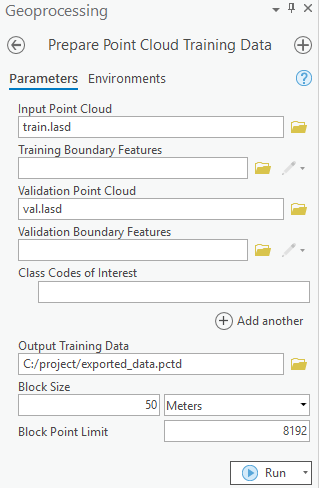</p>

<center>Figure 1. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data tool</a>.</center>



Here, all the additional attributes are included in the exported data. Later a subset of additional attributes like intensity, number of returns, etc. can be selected that will be considered for training.

After the export is completed at the provided output path, the folder structure of exported data will have two folders, with converted HDF files in them <i>(as shown in figure 2)</i>. The exported training and validation folders will also contain histogram about the distribution of data, that provide additional understanding and can help in tweaking the parameters that are being used in the workflow.

<p align="center">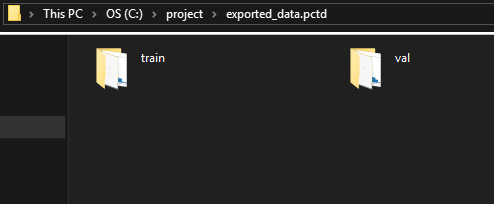</p>

<center>Figure 2. Exported data.</center>

_**Preparing the data:**_

For `prepare_data()`, deciding the value of `batch_size` depends on the available RAM or VRAM depending upon whether CPU or GPU is being used. And `transforms` can be used for introducing rotation, jitter, etc. in the dataset. `data.classes` can be used to verify what classes will the model be learning about.

In this sample notebook X, Y, Z, Red, Blue, and Green are considered for training the model, so all three: 'Red', 'Blue', and 'Green' is selected as `extra_features`. The names of the classes are also defined using `class_mapping`, which are saved inside the model, for future reference.

In case of class imbalance, `classes_of_interest` and `min_points` parameters can be used to filter out less relevant blocks. 

In [ ]:
output_path = r'C:\project\exported_data.pctd'

In [ ]:
colormap = {'0':[255,69,0], '18':[253,247,83]}

In [ ]:
data = prepare_data(output_path, 
                    dataset_type='PointCloud',
                    batch_size=2,
                    min_points=800,
                    transforms=None,
                    color_mapping=colormap,
                    extra_features=['red', 'blue', 'green'],
                    class_mapping={'18':'car','0':"background"})

In [ ]:
data.classes

## Visualization of prepared data

`show_batch()` helps in visualizing the exported data.

In [ ]:
data.show_batch(rows=1)

## Training the model

First, the PointCNN model object is created, utilizing the prepared data.

In [ ]:
pc = PointCNN(data)

Next, `lr_find()` function is used to find the optimal learning rate. It controls the rate at which existing information will be overwritten by newly acquired information throughout the training process. If no value is specified, the optimal learning rate will be extracted from the learning curve during the training process.

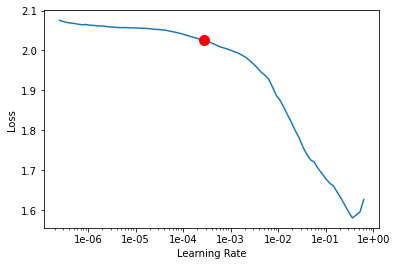

0.0002754228703338166

In [7]:
pc.lr_find()

`fit()` is used to train the model, where a new 'optimum learning rate' is automatically computed or the previously computed optimum learning rate can be passed <i>(any other user-defined learning rate can also be used.).</i>

If `early_stopping` is set to 'True', then the model training will stop when the model is no longer improving, regardless of the `Max Epochs` parameter value specified. The best model is selected based on the metric selected in the `monitor` parameter. A list of available metrics that can be used in `monitor` can be known using the `available_metrics` property.

An 'epoch' means the dataset will be passed forward and backward through the neural network one time, so if `Iters_per_epoch` is used then instead of complete data, a subset of data is passed per epoch. To track information like gradients, losses, metrics, etc. while the model training is in progress, `tensorboard` can be set to 'True'.


In [37]:
pc.available_metrics

['valid_loss', 'accuracy', 'precision', 'recall', 'f1']

In [38]:
pc.fit(20, 0.0002754228703338166, monitor='f1', tensorboard=True, early_stopping=True)

Monitor training on Tensorboard using the following command: 'tensorboard --host=DELDEVD038 --logdir="C:\Users\vai11025\Desktop\sitescan\cars-15 m block\training_data.pctd\training_log"'


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.036672,0.039147,0.983295,0.869097,0.788823,0.811299,54:08
1,0.035641,0.036635,0.985743,0.877212,0.811648,0.832864,53:52
2,0.035747,0.036269,0.985590,0.863960,0.799648,0.820435,54:08
3,0.035532,0.036443,0.985335,0.852369,0.794295,0.813295,53:56
4,0.035454,0.037829,0.984680,0.859983,0.794513,0.813838,54:05
5,0.034591,0.040312,0.982558,0.866561,0.789968,0.811450,53:44
6,0.033419,0.040615,0.982502,0.862325,0.788621,0.810044,54:26


Epoch 7: early stopping


## Visualization of results in notebook

`show_results()` is used to visualize the results of the model, for the same scene with the ground truth. `compute_precision_recall()` can be used to compute per-class performance metrics, which are calculated based on the validation dataset.

In [ ]:
pc.show_results(rows=1)

## Saving the trained model

The last step related to training is saving the model using `save()` method. Where, apart from model files, performance metrics, a graph of training loss vs validation loss, sample results, etc. are also saved <i>(as shown in figure 5)</i>.

In [ ]:
pc.save('cars_and_background')

## Classification using the trained model

For inferencing, <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model tool</a>, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards can be used <i>(as shown in figure 6)</i>.


<p align="center">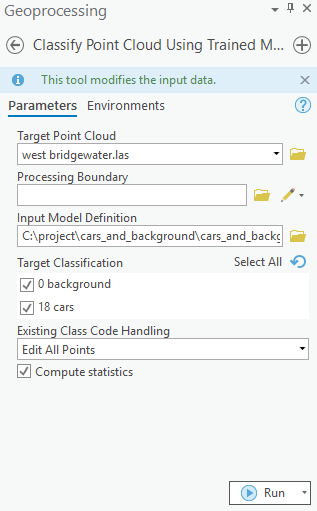</p>

<center>Figure 6. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model tool</a>.</center>


Additional features like, target classification, and class preservation in input data are also available. After the prediction, LAS files will have 'cars points' with class code '18' and the rest of the points with class code '0' <i>(referred as 'Background' in this sample)</i>. 

## Visualization of results in ArcGIS Pro

<p align="center">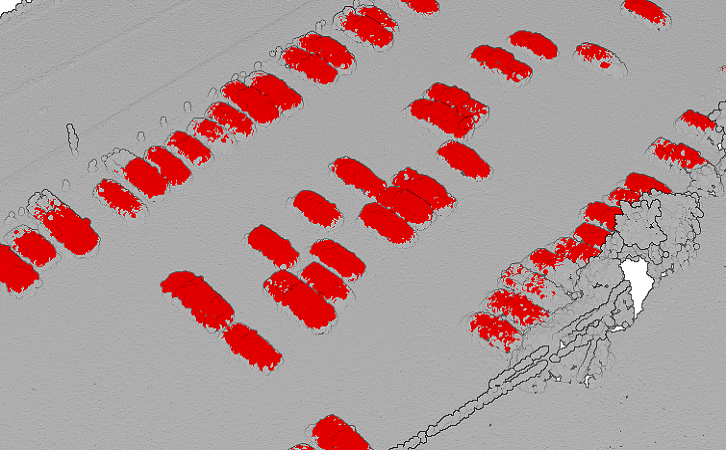</p>

<center>Figure 7. Visualization of results in ArcGIS Pro.</center>

<i> This <a href="https://deldev.maps.arcgis.com/home/webscene/viewer.html?webscene=379f8bcb18744a34998c5a8b29d98f9b" target="_blank">web scene</a>  has the final outputs related to the illustrated sample data in this notebook.</i>

In [19]:
results = gis.content.get('379f8bcb18744a34998c5a8b29d98f9b')
results

<Item title:"Classification of SfM-derived point clouds using deep learning" type:Web Scene owner:vraj_deldev>

## Conclusion

This notebook has walked us through the workflow for training a deep learning model for the classification of points representing 'cars' in SfM-derived point clouds. Using additional attributes, like- Red, Blue, and Green. A similar approach can be applied to classify other objects of interest like trees, buildings, ground, etc.

## References

- Dharmapuri, S., & Tully, M. (2018). Evolution of Point Cloud. LIDAR Magazine. https://lidarmag.com/2018/07/16/evolution-of-point-cloud/



